In [1]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 20 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archi

In [2]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 11.7 MB/s 
     |████████████████████████████████| 51 kB 6.9 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=ce775d3c883fed996b5ace5383d098f0fe5131cb4f1ac387a2ce44d3d9254e4d
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [1]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

AUDIO_DIR = pathlib.Path("data/maestro-v2.0.0")
ANNOTATIONS_FILE = "/content/data/maestro-v2.0.0/maestro-v2.0.0.csv"

if not AUDIO_DIR.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [3]:
class Bach:

  def __init__(self, annotations_file, audio_dir, file_index:Optional[int]=None):  

    '''specifying file_index will bind a preconstructed pretty_midi object to the class
       based off of the param specified at instantiation, else you can use explicit
       methods to create a pretty midi object that is independent from any param within 
       the class'''

    self.annotations = pd.read_csv(f"{annotations_file}")
    self.audio_dir = audio_dir 
    self._SAMPLING_RATE = 44000
    if file_index:
      self.file_index = file_index 
      self.pretty_MIDI = self.__repr__(self.file_index)[0]
      print(f"New Bach Instance Created at file location index: {file_index}\n")
    else:
      print(f"New Bach Instance Created!\n")

  
  def __len__(self):

    '''return total songs in audio_dir'''

    return len(self.annotations)

  
  def __getitem__(self, midi_file_index:Optional[int]=None):

    '''returns both audio sample path and audio sample label of specified location index.
       If no midi_file_index is passed, will return path and labels for all file in dir'''

    if midi_file_index:
      audio_sample_path = self._get_audio_sample_path(midi_file_index)
      label = self._get_audio_sample_label(midi_file_index)
    else:
      audio_sample_path = self._get_audio_sample_path()
      label = self._get_audio_sample_label()
    return audio_sample_path, label 

  
  def __repr__(self, file_index):
    return self.get_pretty_midi(file_index), self.__getitem__()[0]

  
  def _get_audio_sample_path(self, midi_file_index:Optional[int]=None):

    '''method will return the path of either an individual file specified by location index OR the entire directory'''
    
    filenames = glob.glob(str(self.audio_dir/'**/*.mid*'))
    return filenames[midi_file_index] if midi_file_index \
                                      else filenames 

  
  def _get_audio_sample_label(self, midi_file_index:Optional[int]=None):
    return self.annotations.iloc[midi_file_index, 5] if midi_file_index \
                                                     else self.annotations['duration']
  
  
  def get_pretty_midi(self, midi_file_index:int):
    
    '''retrieves pretty_midi object'''
    
    pm = pretty_midi.PrettyMIDI(self.__getitem__(midi_file_index)[0])
    return pm

  
  #DATA VISUALIZATION METHODS
  def display_audio(self, pm:pretty_midi.PrettyMIDI, seconds=30):
    
    '''generates a mini .wav player in the markdown cell'''
    
    waveform = pm.fluidsynth(fs=self._SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*self._SAMPLING_RATE]
    return display.Audio(waveform_short, rate=self._SAMPLING_RATE)

  
  def fetch_inspect_MIDI_instrument(self, pm:pretty_midi.PrettyMIDI, show:Optional[bool]=False):
    
    '''retrieves instrument(s) in song, right now just [0], and shows data if show==True'''
    
    instrument = pm.instruments[0] 
    instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
    if show:
      print("\n*-------------------------------------------*")
      print(f"{'            '} \033[1;36mINSTRUMENT INFORMATION\033[0m")
      print(f"*-------------------------------------------*")
      print(f"\033[0;34m{' '}NUMBER_OF_INSTRUMENTS:\033[0m {len(pm.instruments)}")
      print("*-------------------------------------------*")
      print(f"\033[0;34m{' '}INSTRUMENT_NAME:\033[0m {instrument_name}") 
      print("*-------------------------------------------*") 
      for i, note in enumerate(instrument.notes[:10]):
        note_name = pretty_midi.note_number_to_name(note.pitch)
        duration = note.end - note.start
        print(f"{' '}{i}: \033[0;31mPITCH\033[0m={note.pitch}, \033[0;32mNOTE_NAME\033[0m={note_name}, \033[0;33mDURATION\033[0m={duration:.4f}\n")
    print("*-------------------------------------------*") 
    print("\n")
    return instrument, instrument_name

  
  def midi_to_notes_df(self, 
                       midi_file_index:Optional[int]=None,
                       prettyMidi:Optional[pretty_midi.PrettyMIDI]=None, 
                       midi_file:Optional[str]=None) -> pd.DataFrame:
    
    '''if pm is given, default to the instantiated pm object, 
       else custom index with same method!'''
    
    if midi_file_index:
      instrument = self.get_pretty_midi(midi_file_index).instruments[0]
    if prettyMidi:
      instrument = prettyMidi.instruments[0]
    if midi_file:
      pm = pretty_midi.PrettyMIDI(midi_file)
      instrument = pm.instruments[0]
    notes = collections.defaultdict(list)
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)#<-sort by start time
    prev_start = sorted_notes[0].start
    for note in sorted_notes:
      start = note.start 
      end = note.end
      notes['pitch'].append(note.pitch)
      notes['start'].append(start)
      notes['end'].append(end)
      notes['step'].append(start - prev_start)
      notes['duration'].append(end - start)
      prev_start = start
    
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

  
  def get_note_names(self, df:pd.DataFrame) -> np.ndarray:
    
    '''remember that this produces a FUNC'''
    
    return np.vectorize(pretty_midi.note_number_to_name)

  
  def plot_piano_roll(self, notes:pd.DataFrame, count:Optional[int]=None):
    if count:
      title = f"First {count} notes"
      plt.figure(figsize=(28,12))
    else:
      title = f"Entire track"
      count = len(notes['pitch'])
      plt.figure(figsize=(32,12))
    
    x = np.stack([notes['pitch'], notes['pitch']], axis=0)
    y = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(y[:, :count], 
             x[:, :count], 
             color="m", 
             marker=".",
             markersize=8,
             markerfacecolor="b",
             snap=True)
    plt.xlabel('Time (s)')
    plt.ylabel('Pitch')
    _ = plt.title(title)

  
  def plot_note_distributions(self, notes_df:pd.DataFrame, drop_percentile=2.5):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)
    sns.histplot(notes_df, x="pitch", bins=20, kde=True)

    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes_df['step'], 100 - drop_percentile)
    sns.histplot(notes_df, x="step", bins=np.linspace(0, max_step, 21))

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes_df['duration'], 100 - drop_percentile)
    sns.histplot(notes_df, x="duration", bins=np.linspace(0, max_step, 21))
  
  
  def notes_to_MIDI_file(
    self,
    notes:pd.DataFrame, 
    out_file:str, 
    instrument_name:str, 
    velocity:int=100) -> pretty_midi.PrettyMIDI:
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi \
                        .Instrument(program=pretty_midi \
                        .instrument_name_to_program(instrument_name))
    prev_start = 0 
    for i, note in notes.iterrows():
      start = float(prev_start + note['step'])
      end = float(start + note['duration'])
      note = pretty_midi.Note(velocity=velocity,
                              pitch=int(note['pitch']),
                              start=start,
                              end=end)
      instrument.notes.append(note)
      prev_start = start
    
    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm 
    



rose = Bach(annotations_file=ANNOTATIONS_FILE, 
            audio_dir=AUDIO_DIR, 
            file_index=666)


kita = Bach(annotations_file=ANNOTATIONS_FILE,
            audio_dir=AUDIO_DIR,
            file_index=None)

New Bach Instance Created at file location index: 666

New Bach Instance Created!




*-------------------------------------------*
             INSTRUMENT INFORMATION
*-------------------------------------------*
 NUMBER_OF_INSTRUMENTS: 1
*-------------------------------------------*
 INSTRUMENT_NAME: Acoustic Grand Piano
*-------------------------------------------*
 0: PITCH=69, NOTE_NAME=A4, DURATION=0.1302

 1: PITCH=81, NOTE_NAME=A5, DURATION=0.6641

 2: PITCH=48, NOTE_NAME=C3, DURATION=0.3086

 3: PITCH=70, NOTE_NAME=A#4, DURATION=0.2513

 4: PITCH=58, NOTE_NAME=A#3, DURATION=0.0742

 5: PITCH=64, NOTE_NAME=E4, DURATION=0.0846

 6: PITCH=60, NOTE_NAME=C4, DURATION=0.0599

 7: PITCH=82, NOTE_NAME=A#5, DURATION=0.8242

 8: PITCH=76, NOTE_NAME=E5, DURATION=0.0456

 9: PITCH=60, NOTE_NAME=C4, DURATION=0.0573

*-------------------------------------------*


*-------------------------------------------*




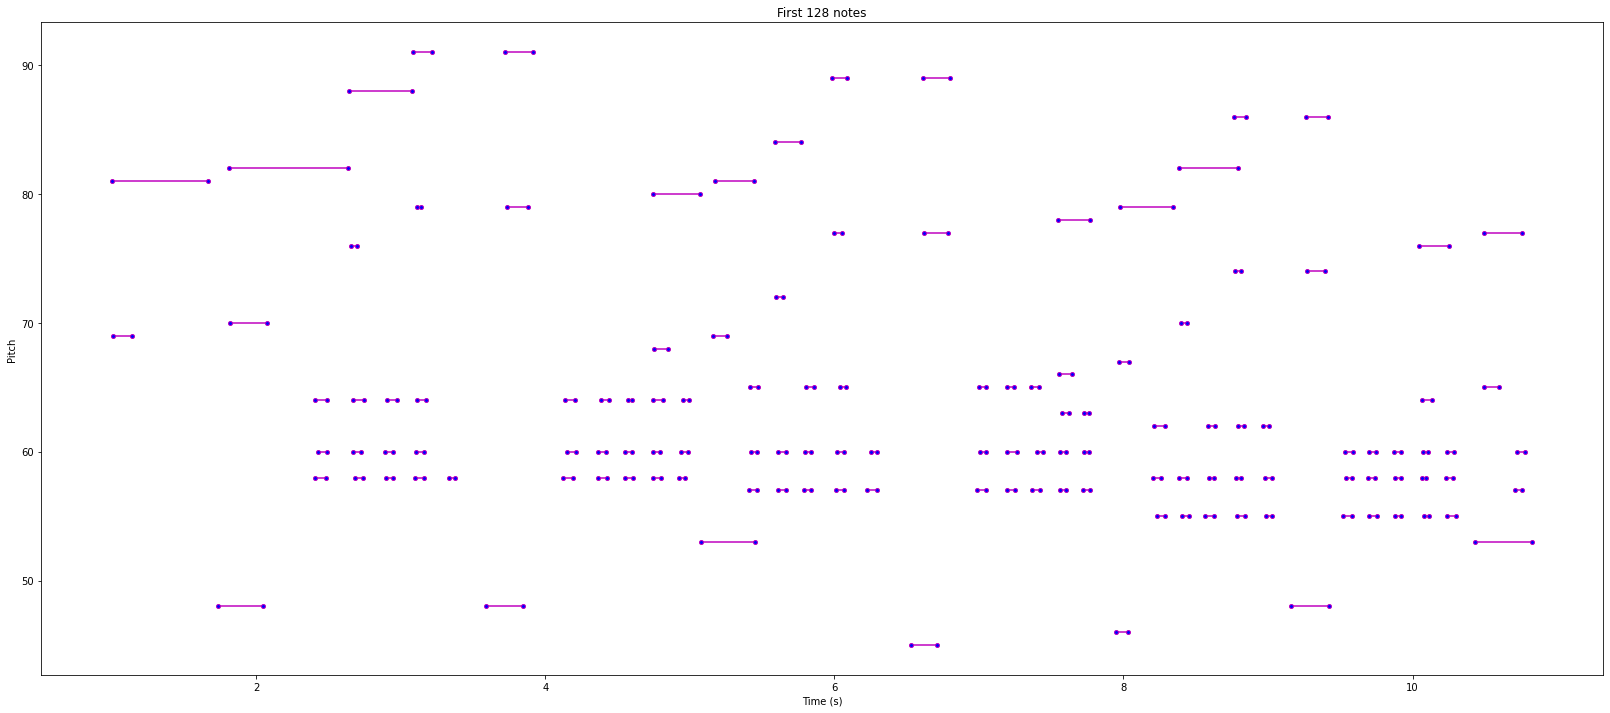

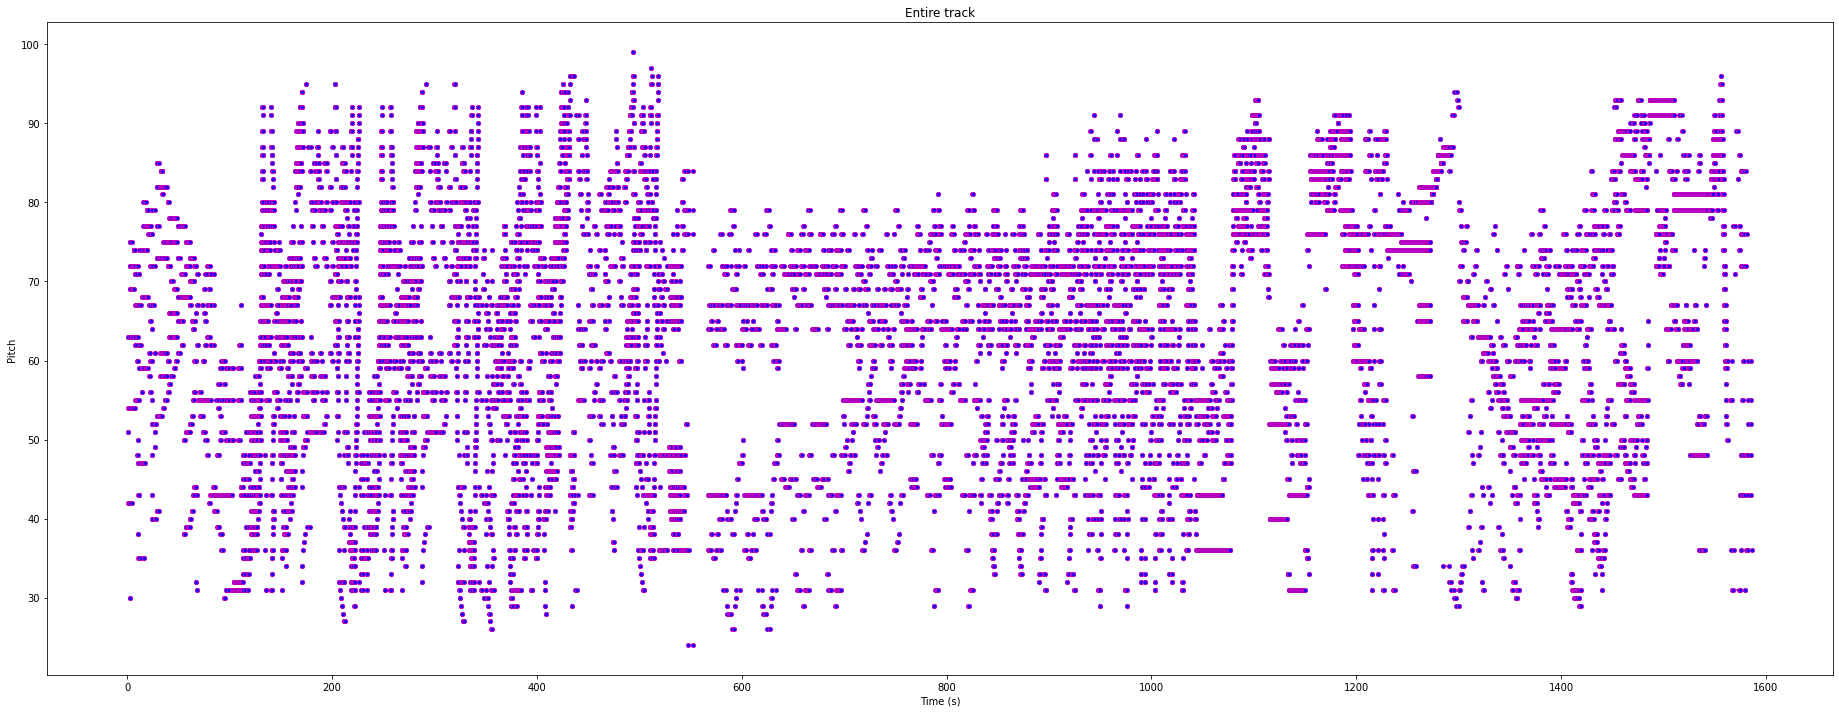

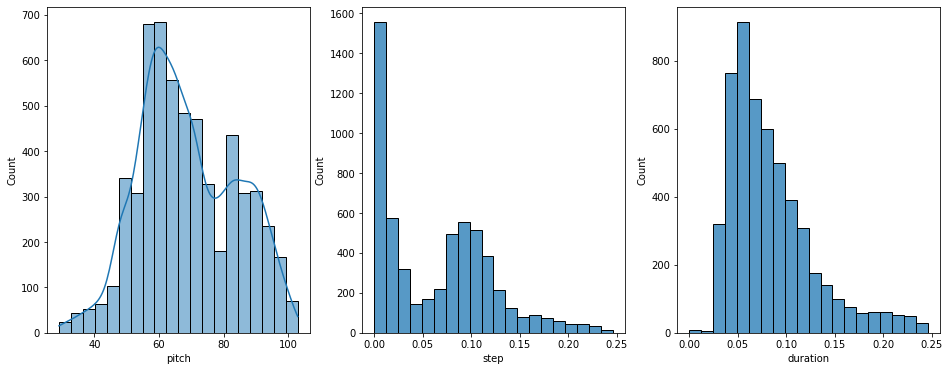

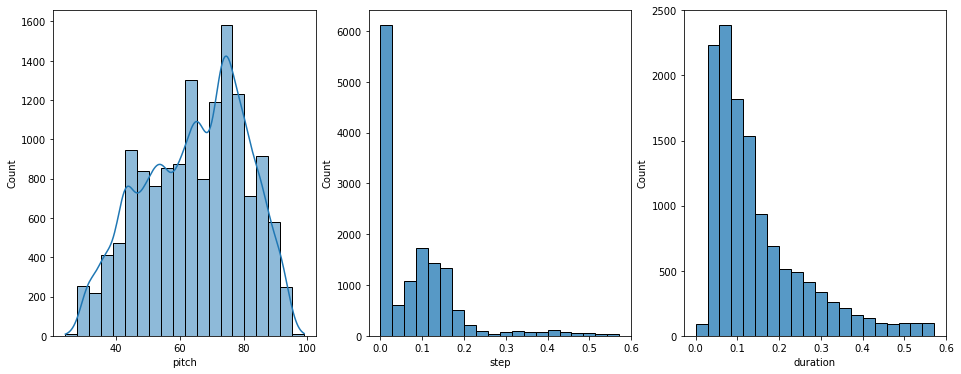

In [4]:
#rose.display_audio(rose.pretty_MIDI)

pm = kita.get_pretty_midi(669) #<-index number of the sample we are inspecting
#kita.display_audio(pm)

instrument1 = rose.fetch_inspect_MIDI_instrument(rose.pretty_MIDI, show=True)
instrument2 = kita.fetch_inspect_MIDI_instrument(pm)

#these perform the same function but using different params to specify different files:
song1 = rose.midi_to_notes_df(prettyMidi=rose.pretty_MIDI)
song2_cust_i = kita.midi_to_notes_df(midi_file_index=6)


rose.plot_piano_roll(song1, count=128)
kita.plot_piano_roll(song2_cust_i)

rose.plot_note_distributions(song1)
kita.plot_note_distributions(song2_cust_i)

EXAMPLE = 'example.midi'
example_midi_file = rose.notes_to_MIDI_file(notes=song1,
                                            out_file=EXAMPLE,
                                            instrument_name=instrument1[1])
#rose.display_audio(example_midi_file)

In [ ]:
'''

Feature-Finders listen for simple time-events such as notes or peaks or pulses.
Measure-Takers notice certain patterns of time-events like 3/4, 4/4, 6/8.
Difference-Finders notice that figure X is like figure Y, but higher by a fifth.
Structure-Builders notice that three phrases form an a regular "sequence."
   
  -taken from:
    Music, Mind, and Meaning
    Marvin Minsky
    Computer Music Journal, Fall 1981, Vol. 5, Number 3

'''

In [33]:
class MusicalAgent(Bach, tf.keras.Model):

  def __init__(self, annotations_file, audio_dir, seq_length=50):
    '''class requires inputs= , outputs= (from Model class) AND seq_length from itself'''
    super().__init__(ANNOTATIONS_FILE, AUDIO_DIR)
    super(Bach, self).__init__(seq_length)
    self.sequence_length = seq_length 
    self.vocab_size = 128
    self.__input_shape = (seq_length, 3)
    self.learning_rate = 0.0018

    self.input_layer = tf.keras.Input(self.__input_shape)
    self.lstm_layer = tf.keras.layers.LSTM(128)
    
    self.loss = self._define_loss()
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    

  def _get_outputs(self, x):
    outputs = {'pitch' : tf.keras.layers.Dense(128, name='pitch')(x),
               'step' : tf.keras.layers.Dense(1, name='step')(x),
               'duration' : tf.keras.layers.Dense(1, name='duration')(x)}
    return outputs 

  def call_layers2model(self):
    '''returns architecture of NN for the intake of data aka Model'''
    x0 = self.input_layer
    x1 = self.lstm_layer(x0)
    y = self._get_outputs(x=x1)
    model = tf.keras.Model(inputs=x0,
                           outputs=y)
    return model

  def _mse_with_positive_pressure(self, y_true:tf.Tensor, y_pred:tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

  def _define_loss(self): 
    loss = {'pitch' : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            'step' : self._mse_with_positive_pressure,
            'duration' : self._mse_with_positive_pressure}
    return loss 

  def _define_callbacks(self):
    callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='./training_checkpoints/ckpt_{epoch}',
                                                    save_weights_only=True),
                 tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                  patience=5,
                                                  verbose=1,
                                                  restore_best_weights=True)]
    return callbacks 

    


In [34]:
from sklearn.model_selection import train_test_split

class Amadeus(MusicalAgent):
  
  '''Amadeus is the class that inherits from Bach the ability to fetch and read music.
     Now this class will learn the music!'''
  
  def __init__(self,
               sampling_rate:Optional[int]=None, 
               file_index:Optional[int]=None):

    '''You cant make a pretty midi object without a file_index, thus a child class that is 
     instantiated without this param will ALSO be devoid of a pretty midi attribute. Calling
     the file index in the child class will trigger the 'file_index' block of the parent class
     init!'''

    super().__init__(ANNOTATIONS_FILE, AUDIO_DIR)#call here even if not required!
    self.key_order = ['pitch', 'step', 'duration']
    #custom sampling rate
    if sampling_rate is not None:
      self.sampling_rate = sampling_rate
    self.model = self.call_layers2model()
    self.compile_model()
  
  ##########PREPROCESSING BLOCK################################################
  def _get_all_notes(self, num_files:int, all_notes:list=[]) -> list:
    '''specify [0] for all_notes and [1] for n_notes(note count)'''
    for files in self.__getitem__()[0][:num_files]:
      notes = self.midi_to_notes_df(midi_file=files)
      all_notes.append(notes)
    all_notes = pd.concat(all_notes)
    n_notes = len(all_notes)
    '''n_notes is now available by specing [1] after this method'''
    return all_notes, n_notes


  def create_training_dataset(self, num_files:int):

    '''create a dataset consiting of n files where n is the num_files.
       ***************************************************************
       num_files(int): the number of files to add to the dataset, 
       all_notes(list)=[] : an empty container'''

    all_notes = self._get_all_notes(num_files)[0]
    n_notes = self._get_all_notes(num_files)[1]
    training_notes = np.stack([all_notes[key] for key in self.key_order], axis=1)
    training_ds = tf.data.Dataset.from_tensor_slices(training_notes)
    print(f"\033[0;31mTraining dataset derived from\033[0m {num_files} \033[0;31mfiles which consists of\033[0m {n_notes} \033[0;31mnotes!\033[0m")
    return training_ds


  def create_sequences(self,
                       dataset:tf.data.Dataset,
                       seq_length:Optional[int]=50,
                       vocab_size=128,
                       show_spec:Optional[bool]=False) -> tf.data.Dataset:
    '''returns tf dataset in sequence form'''
    seq_length = seq_length + 1
    windows_ds = dataset.window(seq_length, shift=1,
                                stride=1, drop_remainder=True)
    
    #these are both functions
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows_ds.flat_map(flatten)

    #normalize note pitch
    def scale_pitch(x):
      x = x / [vocab_size, 1.0, 1.0]
      return x 

    def split_labels(sequences):
      inputs = sequences[:-1]
      labels_dense = sequences[-1]
      labels = {key : labels_dense[i] for i, key in enumerate(self.key_order)}
      return scale_pitch(inputs), labels 

    seq_ds = sequences.map(split_labels, 
                                 num_parallel_calls=tf.data.AUTOTUNE)
    if show_spec:
      print(f"Sequence Map:\n {seq_ds.element_spec}\n")
    return seq_ds


  def batch_ds(self, num_files:int, seq_len:int, seq_ds, batch_size:Optional[int]=64):
    
    '''last arg is a dataset of a song broken into seq_lenSequences.
     batch examples and config dataset for interperentation. Takes in
     the create_training_dataset -> create_sequences ds as "seq_ds"'''

    '''batch_size is set to 64 by default'''

    n_notes = self._get_all_notes(num_files)[1] #n_notes value from class
    buff = n_notes - seq_len #number of items in dataset
    train_ds = (seq_ds \
                .shuffle(buff).batch(batch_size, drop_remainder=True) \
                .cache().prefetch(tf.data.experimental.AUTOTUNE))
    return train_ds


  def _parse_train_test(self, notes):
    x = np.stack([notes['pitch'], notes['pitch']], axis=0)
    y = np.stack([notes['start'], notes['end']], axis=0)
    X_train, X_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=42)
    return X_train, X_test, y_train, y_test


  #####################MODEL BLOCK##################
  def compile_model(self):
    '''compiles model with learning params'''
    return self.model.compile(loss=self.loss,
                              optimizer=self.optimizer,
                              metrics=['accuracy'])
    
  def practice_music(self, training_dataset, epochs:int):
    '''fits the model with epochs and callbacks'''
    history = self.model.fit(x=training_dataset,
                             epochs=epochs,
                             verbose=1,
                             callbacks=self._define_callbacks())
    return history

  
  def data_evaluation(self, training_dataset):
    '''evaluates data based on compiled model'''
    print(f"\033[0;34mEVALUATION BASED ON THE TRAINING DATA: \n\033[0m")
    return self.model.evaluate(training_dataset)


  def show_feature_eval_dict(self, training_ds):
    '''dict of evaluated features based on training ds(pre train)'''
    x = enumerate(self.data_evaluation(training_ds))
    return dict(x)


  def plot_loss_and_accuracy(self, history, 
                             feature_to_analyze:str, training_ds):
    #helper function block
    history_number = input("Enter the history number: ")
    nodes = input("Enter the node settings: ")
    epochz = input("How many epochs? ")
    opt = input("Enter the optimizer: ")
    settings = f"HISTORY NUMBER:{history_number}===>{epochz}E, OPT:{opt}, NODES:{nodes}"
    train_loss = history.history[f"{feature_to_analyze}_loss"]
    train_acc = history.history[f"{feature_to_analyze}_accuracy"]
    fig = plt.figure(figsize=(20,10))
    #subplot1
    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label=f"Train {feature_to_analyze} Loss", color="red");
    plt.xlabel("Epochs"); plt.ylabel("Loss");
    plt.title(f"Train Loss({feature_to_analyze})");
    plt.legend(loc="best");
    plt.suptitle(settings, ha="center", fontsize=18, bbox={"alpha":0.5, "pad":1});
    #subplot2
    ax_ = fig.add_subplot(122)
    ax_.plot(range(len(train_loss)), train_acc, label=f"Train {feature_to_analyze} Accuracy", color="blue");
    plt.xlabel("Epochs"); plt.ylabel(f"Train {feature_to_analyze} Accuracy");
    plt.title(f"Train Accuracy({feature_to_analyze})");
    plt.legend(loc="best");
    plt.figtext(0.5, -0.1, 
                f"Model loss on the training set: {round((self.data_evaluation(training_ds)[2] * 100), 2)}%\n Model accuracy on the training set: {round((self.data_evaluation(training_ds)[5] * 100), 2)}%", 
                ha="center", fontsize=18, bbox={"facecolor":"orange",   "alpha":0.5, "pad":3})
    print(settings)
      

  def predict_next_note(self,
                        notes: np.ndarray,  
                        temperature: float = 1.0) -> int:
    '''here notes is an nd array of a sequence'''
    assert temperature > 0
    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = self.model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']
  
    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # `step` and `duration` values should be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)


  def improvise(self, song_df:pd.DataFrame, 
                temperature:int, num_predictions:int,
                display_audio:Optional[bool]=False) -> pd.DataFrame:
    #gather a sample of notes from the song and stack pitch, step, duration
    sample_notes = np.stack([song_df[key] for key in self.key_order], axis=1)
    # The initial sequence of notes; pitch is normalized similar to training seq
    #so = the first seq_len amt of rows in song1 samples / an array of vocab size, 1, 1
    input_notes = (sample_notes[:self.sequence_length] / np.array([self.vocab_size, 1, 1]))

    generated_notes=[]
    prev_start = 0
    for _ in range(num_predictions):
      pitch, step, duration = self.predict_next_note(input_notes, temperature)
      start = prev_start + step
      end = start + duration
      input_note = (pitch, step, duration)
      generated_notes.append((*input_note, start, end))
      input_notes = np.delete(input_notes, 0, axis=0)
      input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
      prev_start = start

    prediction = pd.DataFrame(generated_notes, 
                              columns=(*self.key_order, 'start', 'end'))
    if display_audio:
      self.plot_piano_roll(prediction)
      self.plot_note_distributions(prediction)
      out_file = 'prediction1.mid'
      pred_pm = self.notes_to_MIDI_file(prediction, out_file, instrument1[1]) #replace this with class attribute!
      super().display_audio(pred_pm)
      return prediction
    else:
      return prediction 


  



In [35]:
#example of class without params(wanting to specify pretty_midi object explicitly)
mozart = Amadeus()

#example of class with built in pm object based on parameters. Also includes other constructor variables
haydn = Amadeus(sampling_rate=16000,
                file_index=rose.file_index)

New Bach Instance Created!

New Bach Instance Created!



In [8]:
N_SEQUENCES = 50
N_FILES = 5

#create training data from num_files as arg
X_train_raw = haydn.create_training_dataset(N_FILES)

#create ds that breaks raw train into specified n_sequences, show_spec if you wanto to print that
X_train_seq = haydn.create_sequences(X_train_raw, N_SEQUENCES, show_spec=True)

#batch out data, ensuring that seq_len(train_ds) == seq_len(X_train_seq)
train_ds = haydn.batch_ds(num_files=N_FILES,
                          seq_len=N_SEQUENCES,
                          seq_ds=X_train_seq)

Training dataset derived from 5 files which consists of 79822 notes!
Sequence Map:
 (TensorSpec(shape=(50, 3), dtype=tf.float64, name=None), {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None), 'step': TensorSpec(shape=(), dtype=tf.float64, name=None), 'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})



In [19]:
haydn.show_feature_eval_dict(train_ds)

EVALUATION BASED ON THE TRAINING DATA: 

622/622 [==============================] - 3s 5ms/step - loss: 5.4612 - duration_loss: 0.2267 - pitch_loss: 4.8470 - step_loss: 0.3875 - duration_accuracy: 0.0000e+00 - pitch_accuracy: 0.0211 - step_accuracy: 0.0384


{0: 5.461216449737549,
 1: 0.2267370969057083,
 2: 4.847019672393799,
 3: 0.3874559700489044,
 4: 0.0,
 5: 0.02107616513967514,
 6: 0.03843448683619499}

In [ ]:
%%time
history1 = haydn.practice_music(training_dataset=train_ds, 
                                epochs=100)

Enter the history number: 1
Enter the node settings: LSTM(128), Dense(1), Dense(1)
How many epochs? 100
Enter the optimizer: Adam
EVALUATION BASED ON THE TRAINING DATA: 

622/622 [==============================] - 4s 5ms/step - loss: 5.4612 - duration_loss: 0.2267 - pitch_loss: 4.8470 - step_loss: 0.3875 - duration_accuracy: 0.0000e+00 - pitch_accuracy: 0.0211 - step_accuracy: 0.0384
EVALUATION BASED ON THE TRAINING DATA: 

622/622 [==============================] - 3s 5ms/step - loss: 5.4612 - duration_loss: 0.2267 - pitch_loss: 4.8470 - step_loss: 0.3875 - duration_accuracy: 0.0000e+00 - pitch_accuracy: 0.0211 - step_accuracy: 0.0384
HISTORY NUMBER:1===>100E, OPT:Adam, NODES:LSTM(128), Dense(1), Dense(1)


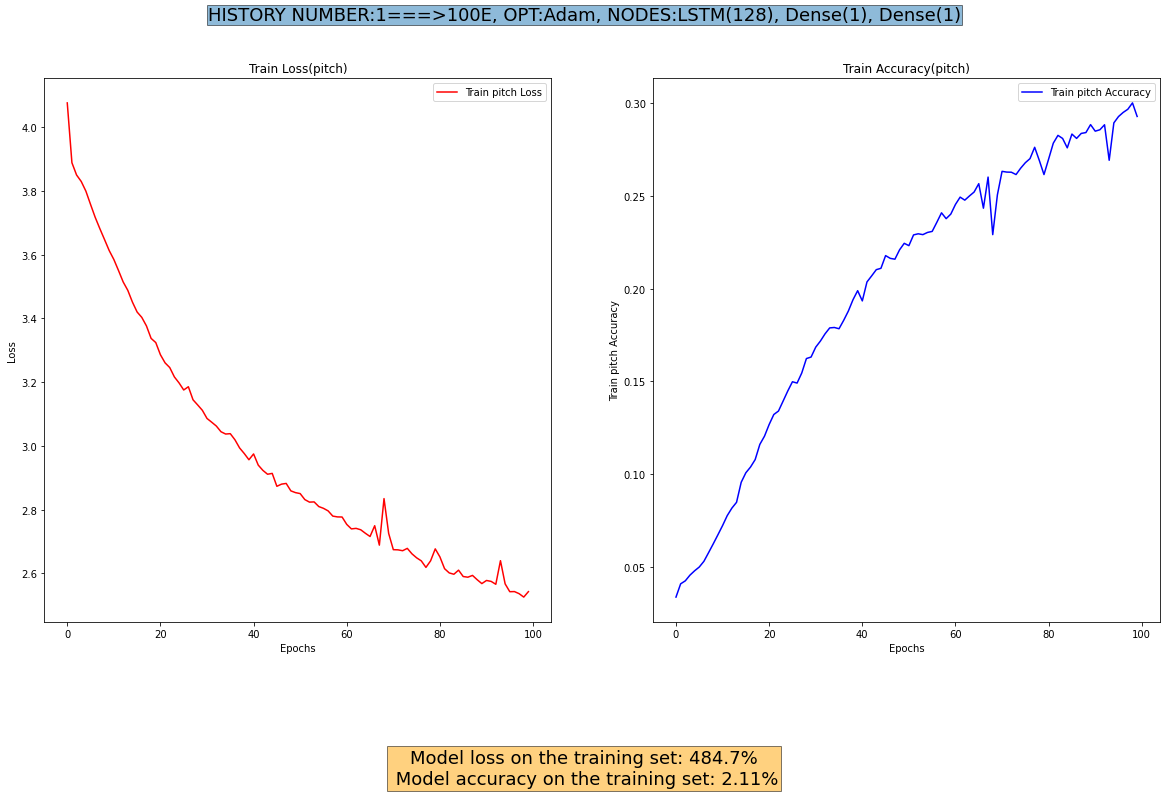

In [18]:
haydn.plot_loss_and_accuracy(history1, "pitch", train_ds)


In [ ]:
history2 = haydn.practice_music(train_ds, 100)

Enter the history number: 2
Enter the node settings: HISTORY1
How many epochs? 100
Enter the optimizer: Adam(lr=0.002)
EVALUATION BASED ON THE TRAINING DATA: 

622/622 [==============================] - 4s 5ms/step - loss: 2.9063 - duration_loss: 0.0709 - pitch_loss: 2.8152 - step_loss: 0.0202 - duration_accuracy: 0.0000e+00 - pitch_accuracy: 0.2338 - step_accuracy: 0.0383
EVALUATION BASED ON THE TRAINING DATA: 

622/622 [==============================] - 3s 5ms/step - loss: 2.9063 - duration_loss: 0.0709 - pitch_loss: 2.8152 - step_loss: 0.0202 - duration_accuracy: 0.0000e+00 - pitch_accuracy: 0.2338 - step_accuracy: 0.0383
HISTORY NUMBER:2===>100E, OPT:Adam(lr=0.002), NODES:HISTORY1


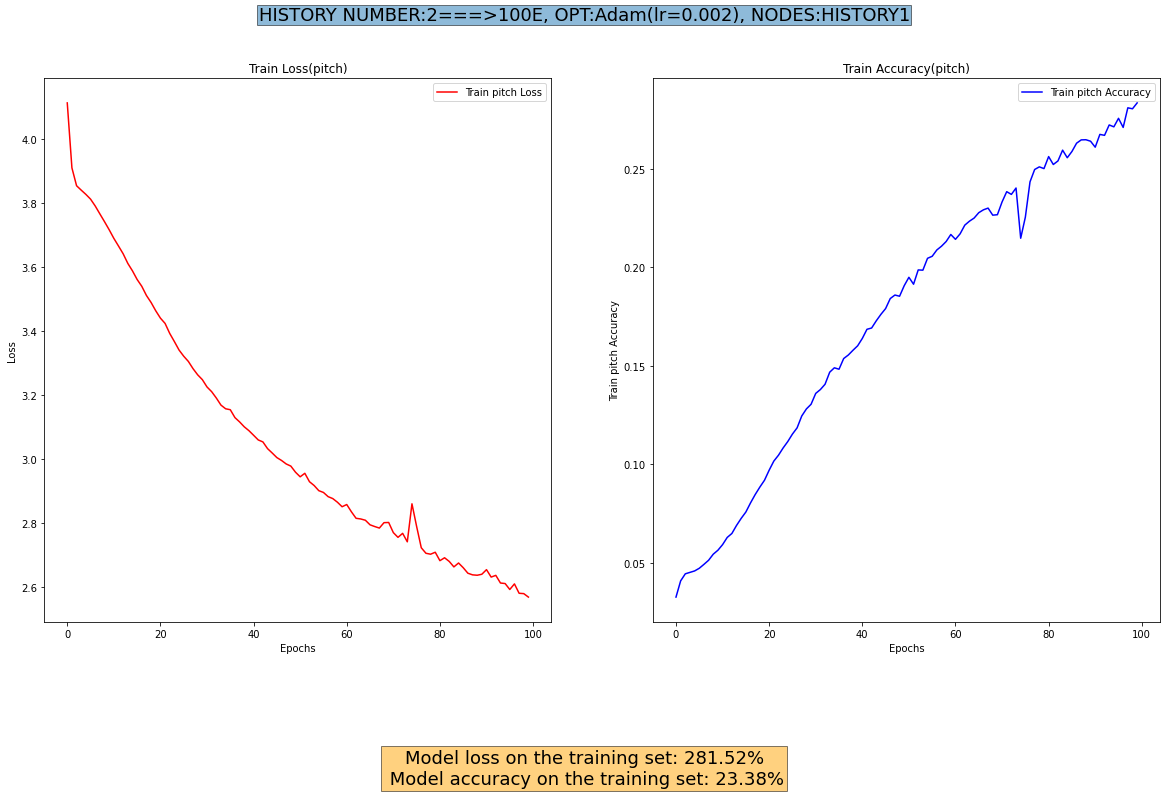

In [26]:
haydn.plot_loss_and_accuracy(history2, "pitch", train_ds)

In [ ]:
history3 = haydn.practice_music(train_ds, 100)

Enter the history number: 3
Enter the node settings: HISTORY1
How many epochs? 100
Enter the optimizer: Adam(lr=0.001)
EVALUATION BASED ON THE TRAINING DATA: 

622/622 [==============================] - 4s 6ms/step - loss: 3.2618 - duration_loss: 0.0959 - pitch_loss: 3.1386 - step_loss: 0.0273 - duration_accuracy: 2.5121e-05 - pitch_accuracy: 0.1638 - step_accuracy: 0.0384
EVALUATION BASED ON THE TRAINING DATA: 

622/622 [==============================] - 3s 5ms/step - loss: 3.2618 - duration_loss: 0.0959 - pitch_loss: 3.1386 - step_loss: 0.0273 - duration_accuracy: 2.5121e-05 - pitch_accuracy: 0.1638 - step_accuracy: 0.0384
HISTORY NUMBER:3===>100E, OPT:Adam(lr=0.001), NODES:HISTORY1


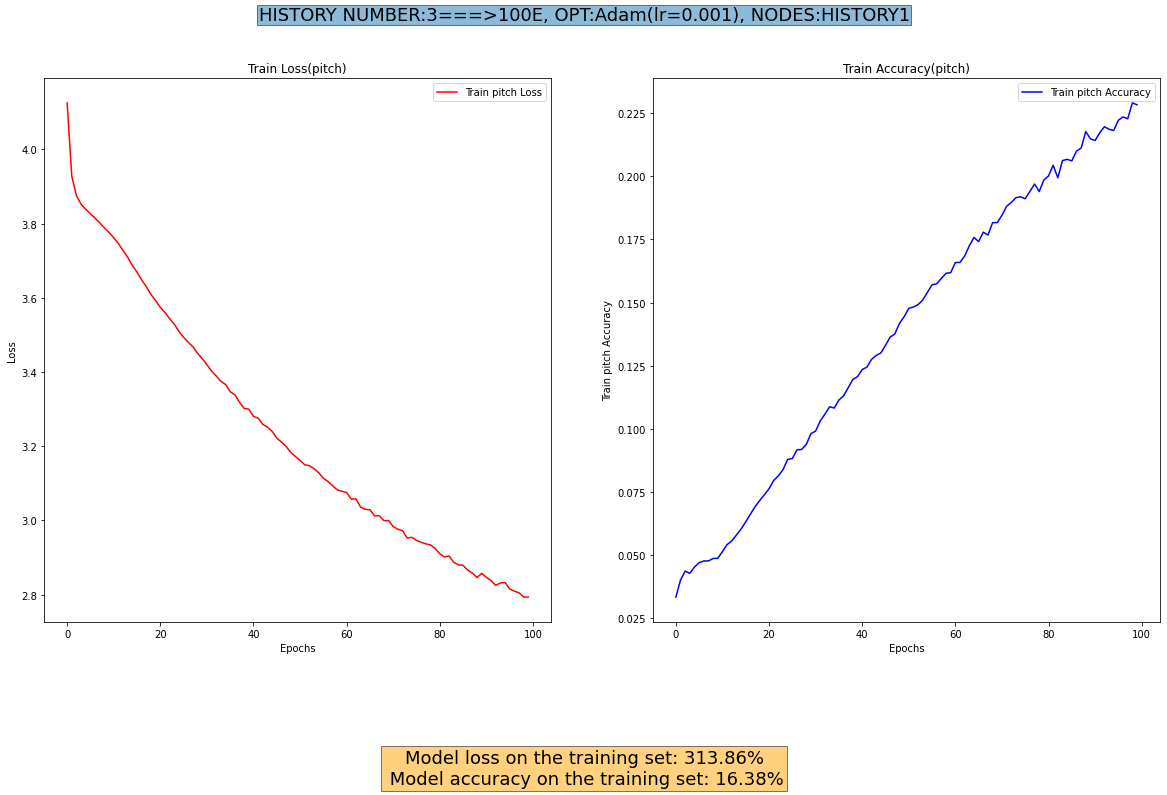

In [32]:
haydn.plot_loss_and_accuracy(history3, "pitch", train_ds)

In [36]:
history4 = haydn.practice_music(train_ds, 100)

Epoch 1/100
622/622 [==============================] - 8s 8ms/step - loss: 4.3023 - duration_loss: 0.1471 - pitch_loss: 4.1084 - step_loss: 0.0469 - duration_accuracy: 2.5121e-05 - pitch_accuracy: 0.0329 - step_accuracy: 0.0381
Epoch 2/100
622/622 [==============================] - 8s 12ms/step - loss: 4.0810 - duration_loss: 0.1285 - pitch_loss: 3.9149 - step_loss: 0.0376 - duration_accuracy: 0.0000e+00 - pitch_accuracy: 0.0395 - step_accuracy: 0.0383
Epoch 3/100
622/622 [==============================] - 9s 14ms/step - loss: 4.0239 - duration_loss: 0.1276 - pitch_loss: 3.8592 - step_loss: 0.0371 - duration_accuracy: 2.5121e-05 - pitch_accuracy: 0.0435 - step_accuracy: 0.0383
Epoch 4/100
622/622 [==============================] - 7s 11ms/step - loss: 4.0069 - duration_loss: 0.1269 - pitch_loss: 3.8432 - step_loss: 0.0368 - duration_accuracy: 2.5121e-05 - pitch_accuracy: 0.0445 - step_accuracy: 0.0382
Epoch 5/100
622/622 [==============================] - 7s 12ms/step - loss: 3.9919 - 

Enter the history number: 4
Enter the node settings: HISTORY1
How many epochs? 100
Enter the optimizer: Adam(0.0018)
EVALUATION BASED ON THE TRAINING DATA: 

622/622 [==============================] - 4s 6ms/step - loss: 2.9941 - duration_loss: 0.0743 - pitch_loss: 2.8924 - step_loss: 0.0274 - duration_accuracy: 2.5121e-05 - pitch_accuracy: 0.2120 - step_accuracy: 0.0384
EVALUATION BASED ON THE TRAINING DATA: 

622/622 [==============================] - 3s 5ms/step - loss: 2.9941 - duration_loss: 0.0743 - pitch_loss: 2.8924 - step_loss: 0.0274 - duration_accuracy: 2.5121e-05 - pitch_accuracy: 0.2120 - step_accuracy: 0.0384
HISTORY NUMBER:4===>100E, OPT:Adam(0.0018), NODES:HISTORY1


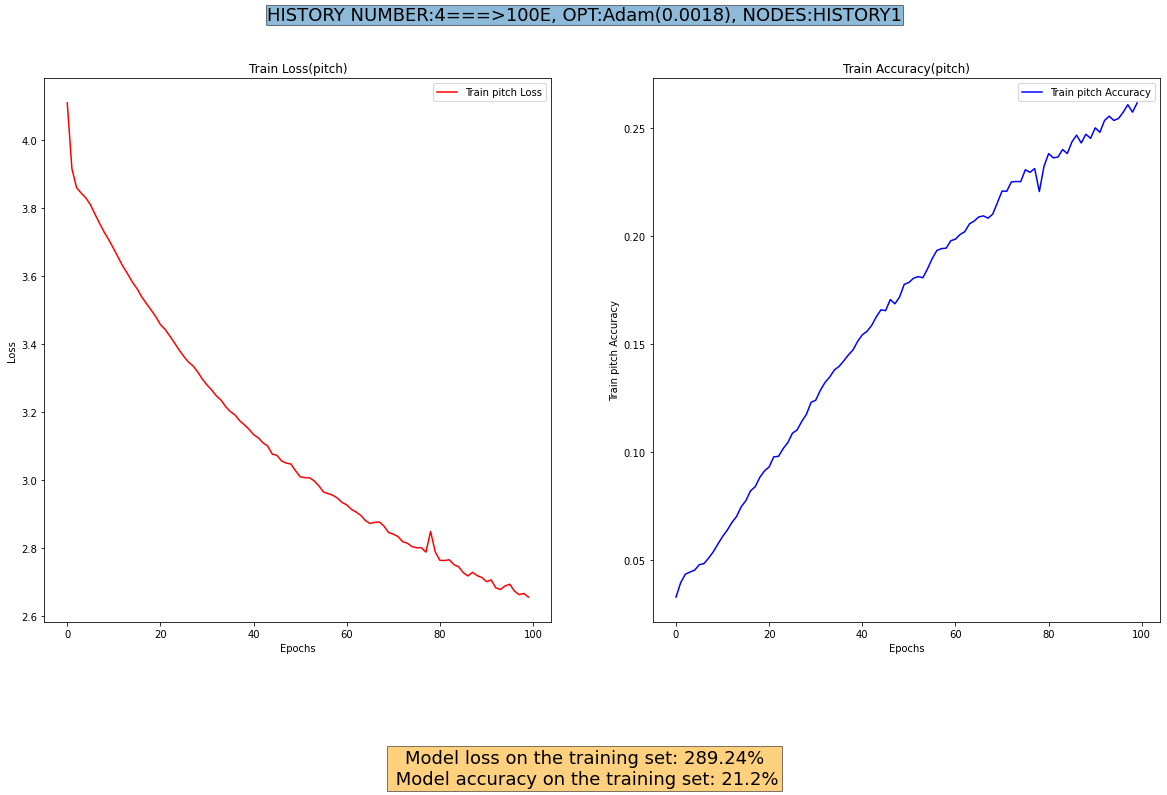

In [37]:
haydn.plot_loss_and_accuracy(history4, "pitch", train_ds)

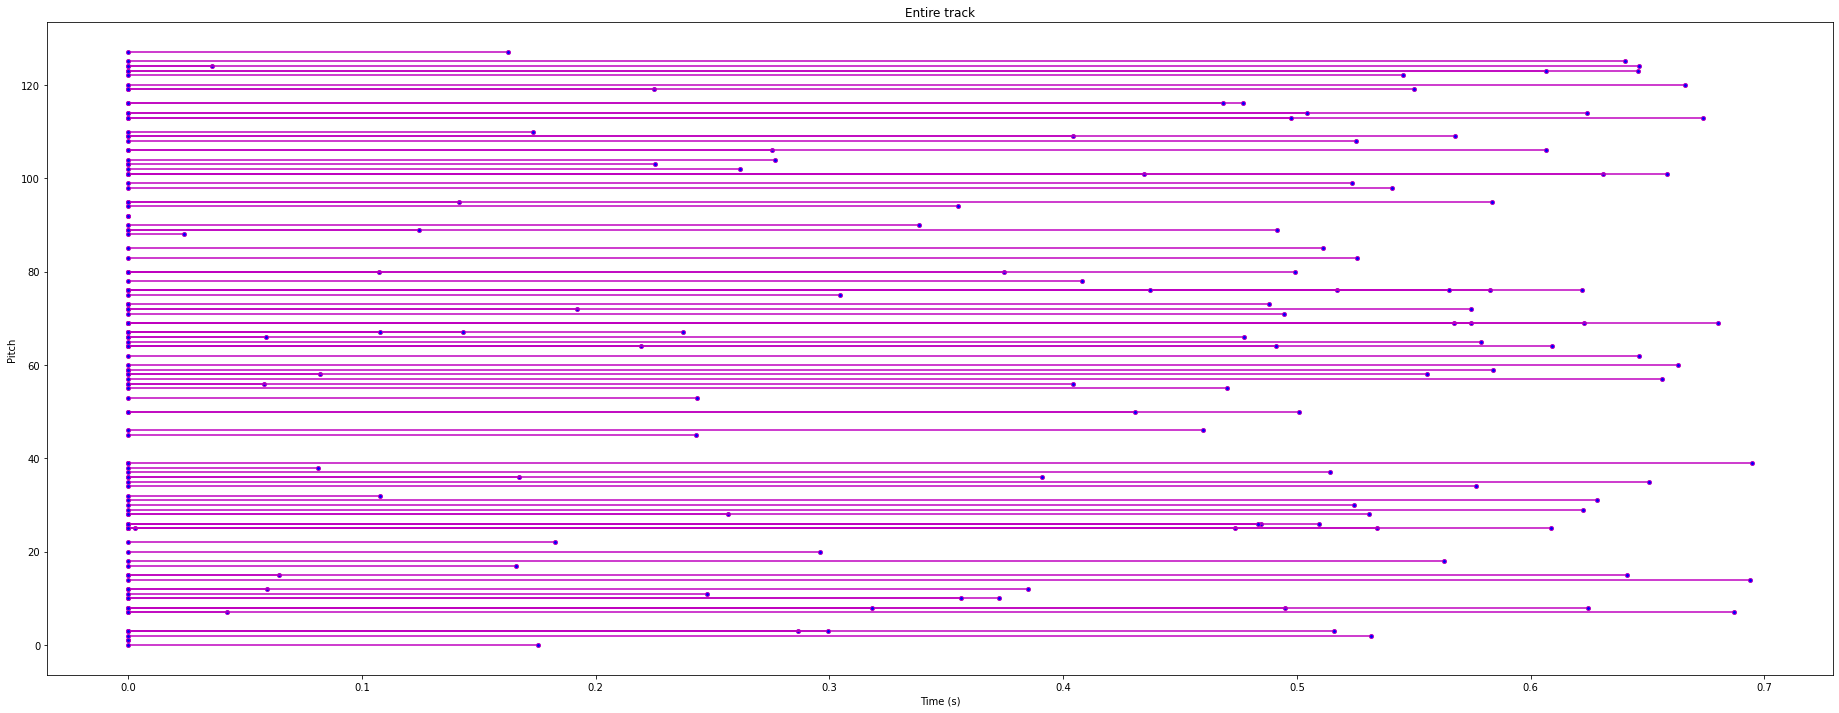

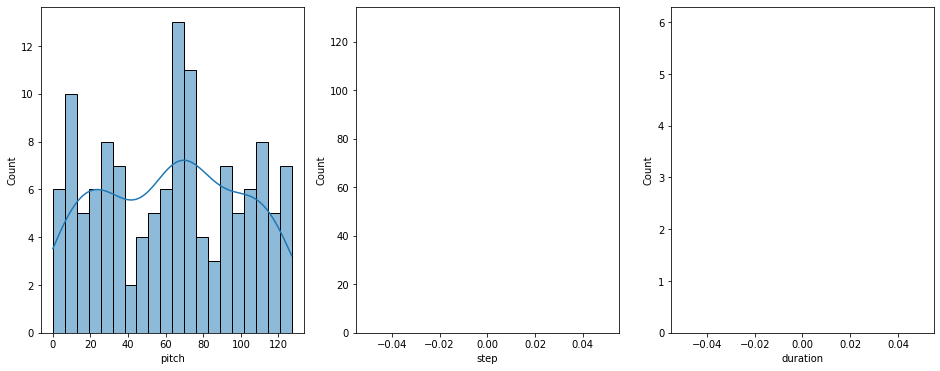

In [ ]:
#make a pred based on the original song df...temperature controls the randomness of the improv
pred1 = haydn.improvise(song_df=song1,
                        temperature=2.0,
                        num_predictions=128,
                        display_audio=True)

In [ ]:
haydn.display_audio(pred1)

AttributeError: ignored